# A/B тест в крупном интернет-магазине
## Введение

### Цели проекта

Цель данного проекта состоит в анализе и оптимизации маркетинговых стратегий интернет-магазина для увеличения его выручки. Для достижения этой цели необходимо:

1. Приоритизировать гипотезы, направленные на увеличение выручки, с использованием фреймворков ICE и RICE.
2. Провести A/B-тестирование и на основании полученных данных определить наиболее эффективные маркетинговые меры.

### Задачи проекта

**Часть 1: Приоритизация гипотез**
1. Применить фреймворк ICE для оценки и приоритизации гипотез.
2. Применить фреймворк RICE для повторной оценки и приоритизации гипотез.
3. Сравнить результаты приоритизации по ICE и RICE, объяснить различия.

**Часть 2: Анализ A/B-теста**
1. Проанализировать данные о заказах и посетителях из файлов /datasets/orders.csv и /datasets/visitors.csv.
2. Построить и проанализировать следующие графики:
   - Кумулятивной выручки по группам.
   - Кумулятивного среднего чека по группам.
   - Относительного изменения кумулятивного среднего чека группы B к группе A.
   - Кумулятивного среднего количества заказов на посетителя по группам.
   - Относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.
3. Построить точечные графики:
   - Количества заказов по пользователям.
   - Стоимостей заказов.
4. Определить перцентили для количества заказов и стоимости заказов, выявить аномальные значения.
5. Рассчитать статистическую значимость различий в среднем количестве заказов и среднем чеке между группами по «сырым» и «очищенным» данным.
6. Принять решение по результатам теста: остановить тест, зафиксировав победу одной из групп, зафиксировать отсутствие различий, или продолжить тест.

### Описание данных

Для выполнения поставленных задач используются два набора данных:

1. **Гипотезы (/datasets/hypothesis.csv)**
   - Hypothesis: краткое описание гипотезы.
   - Reach: охват пользователей по 10-балльной шкале.
   - Impact: влияние на пользователей по 10-балльной шкале.
   - Confidence: уверенность в гипотезе по 10-балльной шкале.
   - Efforts: затраты ресурсов на проверку гипотезы по 10-балльной шкале.

2. **Данные для A/B-теста**
   - **Orders (/datasets/orders.csv)**
     - transactionId: идентификатор заказа.
     - visitorId: идентификатор пользователя, совершившего заказ.
     - date: дата, когда был совершён заказ.
     - revenue: выручка заказа.
     - group: группа A/B-теста.
   - **Visitors (/datasets/visitors.csv)**
     - date: дата.
     - group: группа A/B-теста.
     - visitors: количество пользователей в указанную дату в указанной группе.

### План проекта

1. **Этап 1: Приоритизация гипотез**
   - Оценка гипотез с помощью фреймворка ICE.
   - Оценка гипотез с помощью фреймворка RICE.
   - Сравнение результатов и объяснение различий.

2. **Этап 2: Анализ A/B-теста**
   - Первичная обработка данных.
   - Визуализация и анализ кумулятивных показателей (выручка, средний чек, количество заказов).
   - Выявление и анализ аномальных значений.
   - Расчёт статистической значимости различий между группами.
   - Принятие решения по результатам теста.


## Приоритизация гипотез

In [1]:
#импортируем основные библиотеки, с которыми будем работать
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy import stats as st


### Загрузка и первичная обработка данных

In [2]:
hypo = pd.read_csv('/datasets/hypothesis.csv')
display(hypo.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


Как мы видим, названия столбцов не соответствуют змеиному регистру. Также половина текста гипотез пропадает, лучше это всё исправить.

In [3]:
hypo.columns = hypo.columns.str.lower()
pd.set_option('max_colwidth', 200)
display(hypo.head())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


### Приоритизация гипотез с помощью фреймворка ICE

ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») считается путем произведения нескольких метрик, которые приведены в таблице. Так как вместо ease у нас efforts, мы должны произведение impact и confidence разделить на efforts. 

In [4]:
hypo['ICE'] = round((hypo['impact'] * hypo['confidence']) / hypo['efforts'],2)
display(hypo[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Как мы видим, наиболее высокий показатель ICE у гипотезы №9. Также среди наиболее приоритетных гипотез по этому показателю можно выделить гипотезы под номером 1, 8, 7.

### Приоритизация гипотез с помощью фреймворка RICE

У первого метода есть модификация RICE (R от англ. reach, «охват»). В этом фреймворке мы учитываем оценку охвата пользователей, на которых влияют результаты гипотезы. Рассчитывается он аналогично - к произведению impact и confidence мы добовляем reach и делим на efforts.

In [5]:
hypo['RICE'] = (hypo['reach'] * hypo['impact'] * hypo['confidence']) / hypo['efforts']
display(hypo[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее приоритетные гипотезы по фреймворку RICE - 8, 3, 1, 7. Причём гипотеза под номером 8 значительно лидирует по этому показателю - показатель в 2 раза больше RICE у гипотезы №3, которая находится на втором месте.

### Изменение приоритизации гипотез при использовании разных фреймворков

Как мы видим - результаты в обоих таблицах значительно различаются в нескольких аспектах: 

1. Порядок распределения гипотез меняется в зависимости от фреймворка.
Когда мы посчитали ICE в первой четвёрке приоритетных гипотез оказались номера 9, 1, 8, 7. После смены фреймворка на RICE позиции четырёх приоритетных гипотез поменялись - наиболее приоритетными гипотезами стали 8, 3, 1, 7. Как мы видим в фреймворке RICE остались гипотезы под номером 1, 7, 8, среди которых приоритет не поменяла гипотеза под номером 7 - она на 4 месте. Также стоит отметить, что четверка наименее приоритетных гипотез осталась в пределах наименее приоритетных гипотез, это связано с тем, что лишь один фактор аудитории не может увеличить низкие показатели по другим метрикам. 

2. Разрыв в распределении показателей по ICE и RICE увеличился. 
Как можно заметить при использовании фреймворка ICE разрыв в показателях не такой большой, как при фреймворке RICE - разница в первых трёх наиболее приоритетных гипотезах буквально несколько единиц в первом случае, во втором же показатели различаются в 2-3 раза. Также наиболее приоритетная гипотеза имеет в 16 раз выше показатель, чем наименее приоритетная гипотеза в первом случае, во втором случае наиболее приоритетная гипотеза имеет показатель в 37 раз выше минимального.


Все изменения выше можно объяснить тем, что мы добавили дополнительную метрику при приоритизации гипотез - Reach (охват), то есть скольких пользователей затронет изменение, которое хотят ввести в гипотезе. Перестановка приоритетов, как и разрыв в показателях связаны именно с этим. Данную метрику необходимо включать, когда изменения в гипотезах влияют на охват пользователей, когда нам нужно приоритизировать гипотезы с учётом того, на скольких пользователей влияют изменения.

Из за того, что охват пользователей может влиять на работу интернет магазина, **лучше приоритизировать гипотезы в соответствии с фреймворком RICE**, и, соответственно, первая гипотеза, которую стоит проверить находится под **номером 8** (7 если считаем от 0).

## Анализ A/B-теста

In [6]:
#загрузим данные
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

display(orders.head())
display(visitors.head())

display(orders.info())
display(visitors.info())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [7]:
#переименуем столбцы, выполним проверку на дубликаты, а также приведем столбцы date к типу datetime
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))


print(orders.duplicated().sum())
print(visitors.duplicated().sum())


display(orders.info())
display(visitors.info())

0
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

In [8]:
# Получаем уникальные visitor_id для каждой группы
group_a_visitors = set(orders[orders['group'] == 'A']['visitor_id'])
group_b_visitors = set(orders[orders['group'] == 'B']['visitor_id'])

# Находим пересечение между группами
common_visitors = group_a_visitors.intersection(group_b_visitors)

if common_visitors:
    print("Число посетителей, которые находятся в обеих группах:", len(common_visitors))
else:
    print("Нет посетителей, которые находятся в обеих группах.")

Число посетителей, которые находятся в обеих группах: 58


### График кумулятивной выручки по группам

Создадим таблицу cumulative_data куммулятивных данных по обеим таблицам

In [9]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

In [10]:
# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])


# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head(5)) 


,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [11]:
# Проверка корректности создания cumulative_data
min_date_orders = orders['date'].min()
max_date_orders = orders['date'].max()
min_date_visitors = visitors['date'].min()
max_date_visitors = visitors['date'].max()

min_date_cumulative = cumulative_data['date'].min()
max_date_cumulative = cumulative_data['date'].max()

print("Min date in orders:", min_date_orders)
print("Max date in orders:", max_date_orders)
print("Min date in visitors:", min_date_visitors)
print("Max date in visitors:", max_date_visitors)
print("Min date in cumulative_data:", min_date_cumulative)
print("Max date in cumulative_data:", max_date_cumulative)

if (min_date_cumulative == min_date_orders == min_date_visitors) and (max_date_cumulative == max_date_orders == max_date_visitors):
    print("Датафрейм cumulative_data создан корректно.")
else:
    print("Ошибка в создании датафрейма cumulative_data.")

Min date in orders: 2019-08-01 00:00:00
Max date in orders: 2019-08-31 00:00:00
Min date in visitors: 2019-08-01 00:00:00
Max date in visitors: 2019-08-31 00:00:00
Min date in cumulative_data: 2019-08-01 00:00:00
Max date in cumulative_data: 2019-08-31 00:00:00
Датафрейм cumulative_data создан корректно.


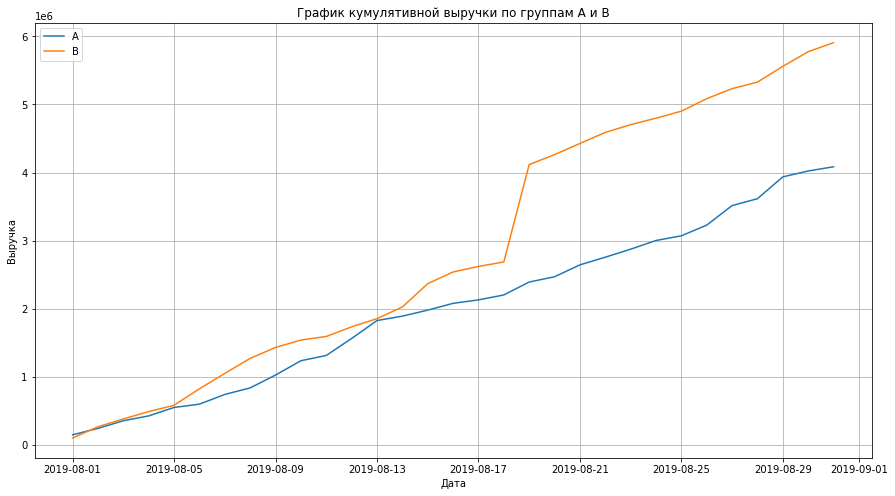

In [12]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

#задаем размер графику
plt.figure(figsize=(15,8))

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.grid()

plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('График кумулятивной выручки по группам А и В')

plt.legend() 

plt.show()

Как можно заметить на графике, первая половина месяца сопровождалась равномерным ростом - рост выручки мало чем отличался у обеих групп (разве что у группы B выручка росла чуть быстрее). Но со второй половины месяца выручка у группы В значительно вырастает - в период с 18 по 20 число происходит резкий рост выручки. Скорее всего его можно объянить значительным увеличением заказов, либо несколькими крупными заказами. Скорее всего без этого всплеска выручка росла бы примерно одинаково у каждой из групп. 

Проверим это - выведем медиану для заказов в период с 18 по 20 августа, и выведем самые крупные заказы в эти дни.

In [13]:
print('Медианное значение заказов в период с 18 по 20 августа:',orders.query(' "2019-08-17" <= date <= "2019-08-21" ')['revenue'].median())
orders.query(' "2019-08-17" <= date <= "2019-08-21" ').sort_values(by='revenue', ascending=False).head()

Медианное значение заказов в период с 18 по 20 августа: 3342.0


,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
949,1347999392,887908475,2019-08-21,60450,A
530,3970235543,2912540959,2019-08-19,43990,A
751,348143148,689129267,2019-08-20,37150,B
527,1570513684,2837914161,2019-08-19,33405,B


Как мы видим, заказ под номером 425 меняет всю картину - заказ на 1.3 миллиона может объяснить такой прирост выручки и среднего чека в эти дни. Для сравнения - медиана в период с 18 по 20 августа составляла 3.3 тысячи рублей, а максимальная цена других заказов не превышает 65 тысяч рублей. Поэтому 425 заказ следует учитывать в дальнейших расчётах.

###  График кумулятивного среднего чека по группам.

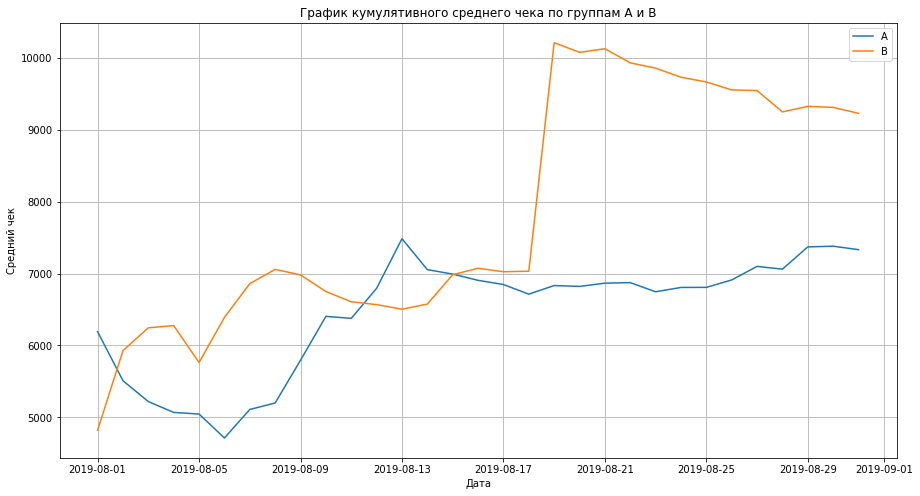

In [14]:
plt.figure(figsize=(15,8))

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')

plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.grid()

plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('График кумулятивного среднего чека по группам А и В')

plt.legend() 

plt.show()

На данном графике мы наблюдаем схожую картину - в районе 18 и 20 дней мы наблюдаем значительное увеличение среднего чека, также можно увидеть тренд на его снижение после 21 августа, что может говорить, что данное увеличение среднего чека у группы В временное явление и обусловлено лишь резким ростом в два конкретных дня. 

Также можно увидеть, что средний чек у группы А постепенно растет в первую половину месяца, а 13 августа обгоняет средний чек группы В. После 15 августа средний чек группы А находится примерно на одном уровне, чего нельзя сказать про средний чек группы В.

### График относительного изменения кумулятивного среднего чека группы B к группе A.

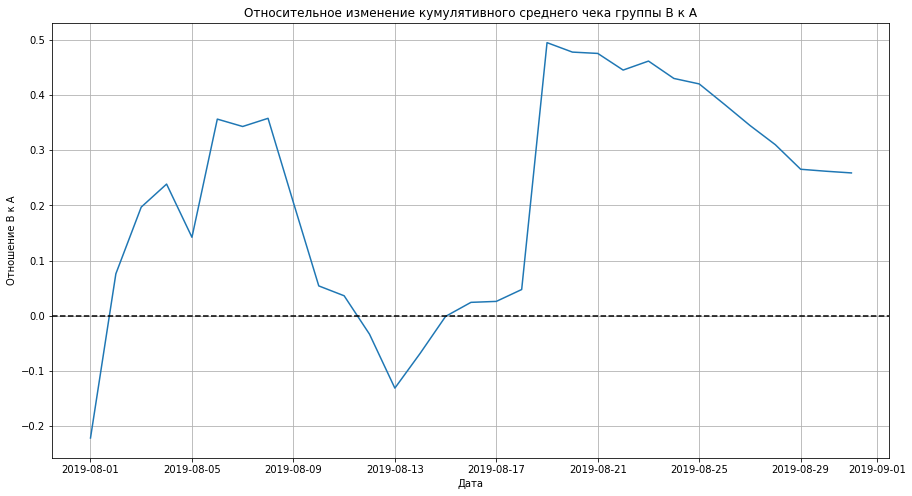

In [15]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(15,8))

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1)

plt.grid()

plt.xlabel('Дата')
plt.ylabel('Отношение В к А')
plt.title('Относительное изменение кумулятивного среднего чека группы B к А')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

Выводы, которые можно сделать по этому графику аналогичны выводам из предыдущего графика по кумулятивному среднему чеку, но данный график будет более наглядным. Как мы видим, наблюдается волнообразный рост среднего чека у группы В с 1 по 10 августа, дальше идет снижение и уже 13 августа (когда средний чек группы А превышал средний чек группы В) мы наблюдаем минимальный средний чек после 1 августа. Дальше идет постепенный рост и в районе 18 числа мы наблюдаем огромный всплеск среднего чека группы В в сравнении с группой А. 

Также на этом графике более наглядно виден тренд на снижение среднего чека группы В после 21 августа.

### График кумулятивного среднего количества заказов на посетителя по группам.

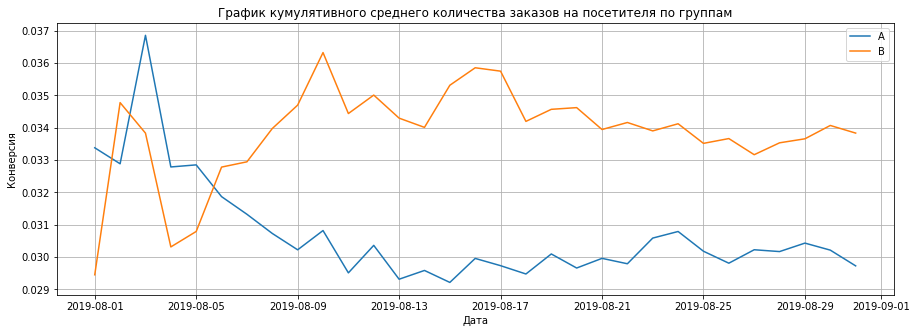

In [16]:
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(15,5))

plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')

plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

plt.grid()

plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')

plt.legend()

plt.show()

Как можно заметить из данного графика, конверсия группы А в первую неделю августа была больше, чем у группы В (кроме 2 августа, в тот  день у группы В конверсия была выше), также максимальная конверсия была у группы А 3 августа, однако после 5 августа мы наблюдаем тренд на снижение конверсии, а уже после 10 августа наблюдается стабилизация этого тренда и конверсия находится в районе 0.030 - 0.031. В группе В после 5 августа наоборот наблюдается тренд на повышение конверсии, а стабилизация конверсии происходит после 17 августа - значение конверсии в период с 17 по 31 августа находятся между 0.033 и 0.034. 

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

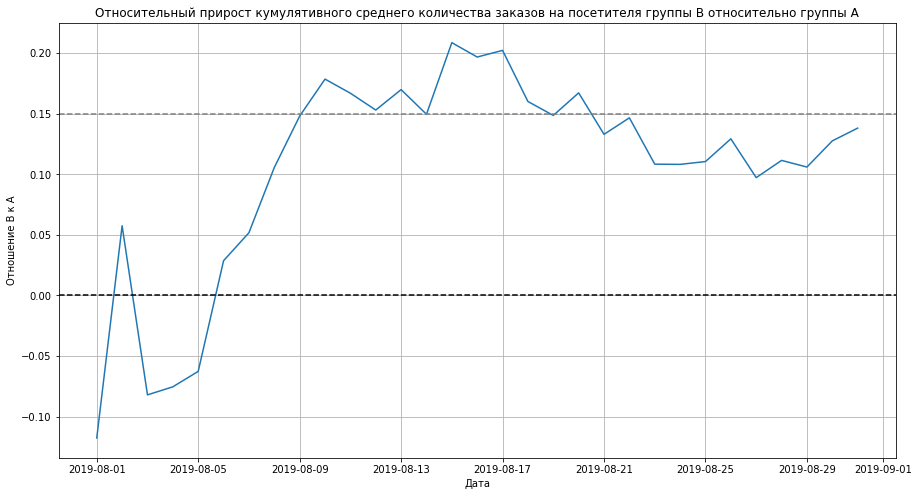

In [17]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(15,8))

plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a']-1)

plt.grid()

plt.xlabel('Дата')
plt.ylabel('Отношение В к А')
plt.title('Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A')

plt.axhline(y=0, color='black', linestyle='--')

plt.axhline(y=0.15, color='grey', linestyle='--')

plt.show()

Как мы видим, и как было видно из предыдущего графика, 2 августа среднее количество заказов у группы В было выше, чем у группы А на 5 %, хотя первые 5 дней августа группа А опережает показатели среднего количества заказов у группы В на 5-10%. Однако уже после 8 августа показатели группы В начинают стремительно расти и в своем пике достигают прироста в 21% относительно группы А, однако к концу месяца показатель относительного прироста конверсии группы В стабилизируется в районе 10-15% прироста.

### Точечный график количества заказов по пользователям.

In [18]:
#Подсчитаем количество заказов по пользователям и посмотрим на результат
orders_by_users = (orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'}))

orders_by_users.columns = ['user_id', 'orders']

display(orders_by_users.sort_values(by='orders', ascending=False).head(10)) 

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть пользователи, которые совершали 5, 8, 9, и 11 заказов. Значительно больше, чем обычный пользователь за неделю. Построим точечную диаграмму числа заказов на одного пользователя:

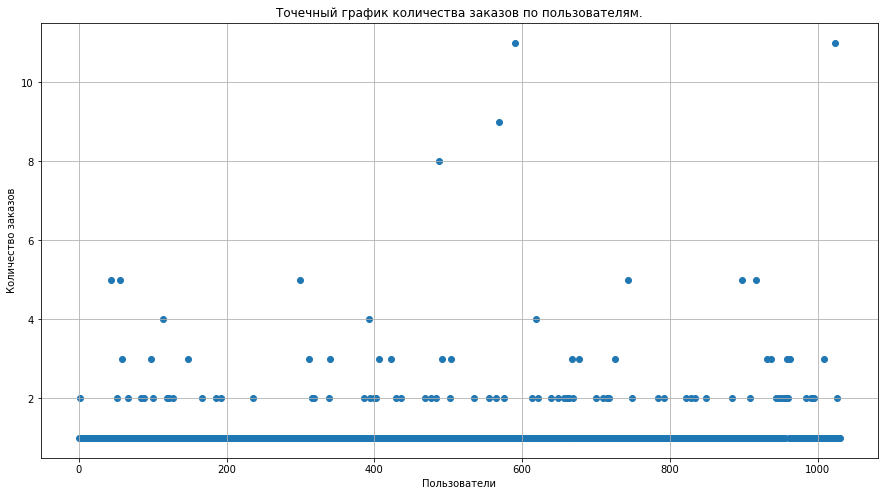

In [19]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(15,8))
plt.grid()

plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.title('Точечный график количества заказов по пользователям.')
plt.scatter(x_values, orders_by_users['orders'])

plt.show()

Как можно заметить, больше всего людей делали 1 заказ, тех, кто сделал два заказа уже не так много. Сделавших 3 заказа и больше - единицы, но по графику говорить об аномальных значениях недостаточно, следует проверить это с помощью определения верхних перцентилей.

### 95-й и 99-й перцентили количества заказов на пользователя. Граница для определения аномальных пользователей.

In [20]:
#посчитаем выборочные перцентили количества заказов на одного пользователя
print(np.percentile(orders_by_users['orders'], [90, 95, 99])) 

[1. 2. 4.]


Не более 5% пользователей оформляли больше 2х заказов. И 10% пользователей заказывали более одного раза. 
Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

###  Точечный график стоимостей заказов.

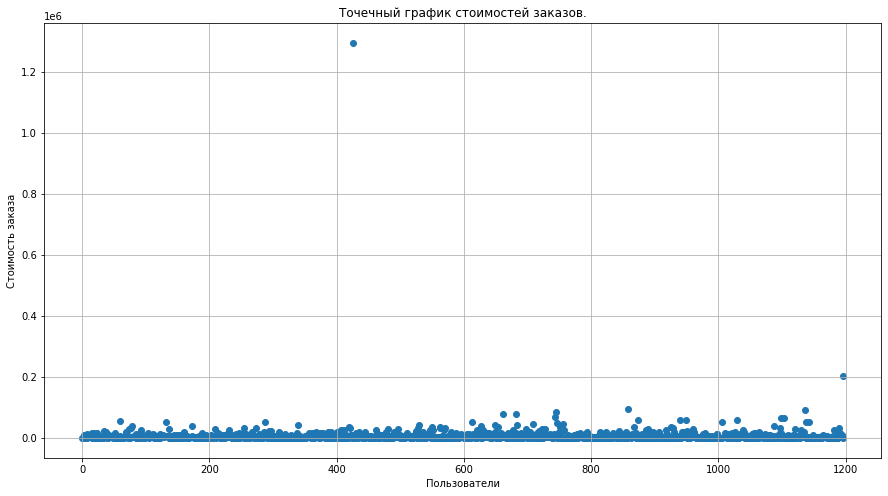

In [21]:
x_values = pd.Series(range(0,len(orders['revenue'])))


plt.figure(figsize=(15,8))
plt.grid()
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.title('Точечный график стоимостей заказов.')
plt.scatter(x_values, orders['revenue']) 

plt.show()

Из за аномального заказа 425 масштаб графика не отражает основную массу стоимостей заказов. Построим график без учета заказа на миллион.

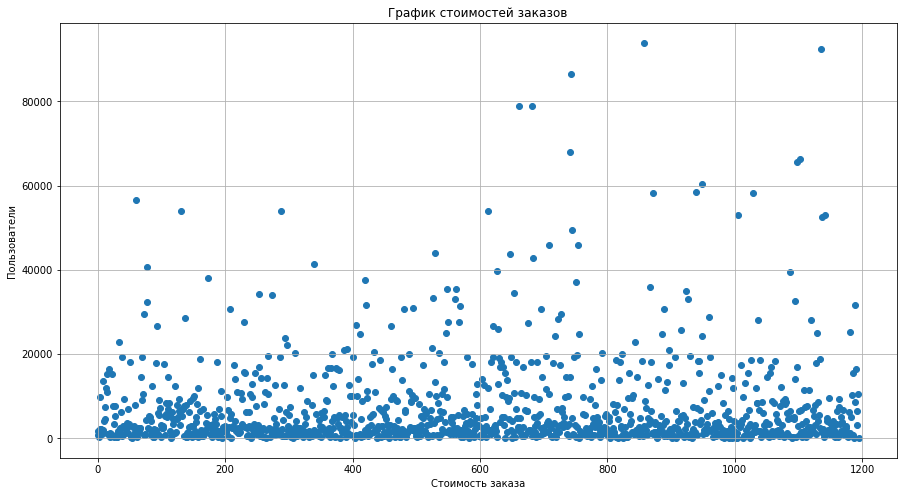

In [22]:
orders_without_anomaly = orders[orders['revenue']<=200000]['revenue']
xn_values = pd.Series(range(0,len(orders_without_anomaly)))
plt.figure(figsize=(15,8))
plt.grid()
plt.xlabel('Стоимость заказа')
plt.ylabel('Пользователи')
plt.title('График стоимостей заказов')
plt.scatter(xn_values, orders_without_anomaly);
plt.show()

Как видно из данного графика, основная масса заказов была сделана в районе до 20 тыс. рублей. Посчитаем персентили, чтобы более точно определить границу аномальных значений.

### 95-й и 99-й перцентили стоимости заказов. Граница для определения аномальных заказов.

In [23]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


Не более 5% заказов дороже 28000 рублей и не более 1% дороже 58233 рублей. Поставим границу определения аномальных заказов на уровне 99 перцентиля.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Посчитаем статистическую значимость различий в среднем числе заказов на посетителя между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы.

**Нулевая гипотеза** Статистически значимых различий в среднем количестве заказов на посетителя между группами по "сырым" данным нет.

**Альтернативная гипотеза** Статистически значимые различия в среднем количестве заказов на посетителя между группами по "сырым" данным есть.

In [24]:
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

data = (
    cumulative_data_a[['date', 'orders', 'revenue', 'visitors']]
    .rename(columns={'orders': 'orders_cummulative_a', 'revenue': 'revenue_cummulative_a', 'visitors': 'visitors_cummulative_a'})
    .merge(
        cumulative_data_b[['date', 'orders', 'revenue', 'visitors']].rename(columns={'orders': 'orders_cummulative_b', 'revenue': 'revenue_cummulative_b', 'visitors': 'visitors_cummulative_b'}),
        on='date',
        how='left'
    )
    .merge(
        visitors[visitors['group'] == 'A'][['date', 'visitors']].rename(columns={'visitors': 'visitors_per_date_a'}),
        on='date',
        how='left'
    )
    .merge(
        visitors[visitors['group'] == 'B'][['date', 'visitors']].rename(columns={'visitors': 'visitors_per_date_b'}),
        on='date',
        how='left'
    )
)

display(data.head(5))


,date,orders_cummulative_a,revenue_cummulative_a,visitors_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_cummulative_b,visitors_per_date_a,visitors_per_date_b
0,2019-08-01,24,148579,719,21,101217,713,719,713
1,2019-08-02,44,242401,1338,45,266748,1294,619,581
2,2019-08-03,68,354874,1845,61,380996,1803,507,509
3,2019-08-04,84,425699,2562,78,489567,2573,717,770
4,2019-08-05,109,549917,3318,101,581995,3280,756,707


Теперь посчитаем статистическую значимость различия в среднем количестве заказов между группами. Создадим переменные orders_by_users_a и orders_by_users_b со столбцами 'user_id', 'orders'. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [25]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [26]:
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

In [27]:
#установим уровень статистической значимости alpha
alpha = 0.05
print('Уровень статистической значимости',alpha)
#применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.
print("p-value = {0:.3f}".format(st.mannwhitneyu(sample_a, sample_b)[1]))

print("Относительный показатель B и A: {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

Уровень статистической значимости 0.05
p-value = 0.017
Относительный показатель B и A: 0.138


При уровне статистической значимости равном 5% мы должны отвергнуть нулевую гипотезу о том, что различий между группами нет. Также относительный прирост группы B относительно группы А составил 13.8%.
Из этого можно сделать вывод о том, что различия по "сырым" данным между группами есть.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами.

Нулевая гипотеза Статистически значимых различий в среднем чеке заказа между группами по "сырым" данным нет.

Альтернативная гипотеза Статистически значимые различия в среднем чеке заказа между группами по "сырым" данным есть

In [28]:
print('p-value = {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный показатель B и A: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.729
Относительный показатель B и A: 0.259


При уровне статистической значимости равном 5% мы принимаем нулевую гипотезу об отсутствии различий между группами. А относительный показатель равный 0.259 говорит о том, что средний чек пользователей из группы B на 25.9% больше, чем у пользователей из группы А.
Из этого делаем вывод о том, что различия по "сырым" данным между группами А и В в среднем чеке отсутствуют.

###  Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

**Нулевая гипотеза** Статистически значимых различий в среднем количестве заказов на посетителя между группами по "сырым" данным нет.

**Альтернативная гипотеза** Статистически значимые различия в среднем количестве заказов на посетителя между группами по "сырым" данным есть.

Избавимся от аномальных значений. Напомню, что за границу аномальных значений я выбрал значения **больше двух заказов и дороже 58234 рублей**. 

In [29]:
many_orders_threshold = np.percentile(orders_by_users['orders'], 95)
expensive_orders_threshold = np.percentile(orders['revenue'], 99)

users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > many_orders_threshold]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > many_orders_threshold]['user_id'],
    ],
    axis=0,
)

users_with_expensive_orders = orders[orders['revenue'] > expensive_orders_threshold]['visitor_id']

abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormal_users.head(5))
print(abnormal_users.shape[0])

1099    148427295
18      199603092
23      237748145
37      249864742
68      457167155
dtype: int64
31


Всего 31 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [30]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [31]:
print('Уровень статистической значимости',alpha)
print('p-value = {0:.3f}'.format(st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Относительный показатель B и A: {0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

Уровень статистической значимости 0.05
p-value = 0.010
Относительный показатель B и A: 0.174


По "очищенным" данным мы также отвергаем нулевую гипотезу об отсутствии различий между группами. Также мы наблюдаем прирост относительного показателя B и А - количество заказов в группе В на 17.4 % больше (по "сырым" данным этот показатель составлял 13.8%)

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Применим статистический критерий Манна-Уитни к полученным выборкам, чтобы получить результат по среднему чеку. Гипотезы не изменились.

**Нулевая гипотеза** Статистически значимых различий в среднем чеке заказа между группами по "очищенным" данным нет.

**Альтернативная гипотеза** Статистически значимые различия в среднем чеке заказа между группами по "очищенным" данным есть

In [32]:
print('Уровень статистической значимости',alpha)
print(
    'p-value = {0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный показатель B и A: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Уровень статистической значимости 0.05
p-value = 0.798
Относительный показатель B и A: -0.020


Полученный результат говорит о том, что мы также не можем отвергнуть нулевую гипотезу об отсутствии различий - то есть различий в среднем чеке нет. Следует отметить, что относительный показатель превосходства В над А значительно упал, по сравнению с этим же показателем только по "сырым" данным - средний чек группы В на 2% ниже, чем у группы А (в то время как по "сырым" данным группа В превосходила группу А по среднему чеку на 25.9%). На этом примере можно заметить, как аномально высокие значения влияют на средний чек.

### Решение по результатам теста 

На мой взгляд, следует остановить A/B-тест,так как мы имеем вполне однозначные результаты, которые одновременно говорят как о победе одной группы над другой, так и об отсутствии различий между группами, а именно:

* Статистические различия есть в среднем количестве заказов на посетителя, у группы B конверсия выше на 17.4%
* Статистических различий нет в среднем чеке нет, у группы В средний чек ниже на 2%, чем у группы А.

Рекомендации бизнесу: 
* На основе полученных данных, можно сказать, что изменения успешно повлияли на увеличение конверсии среди пользователей интернет-магазина, поэтому следует сосредоточиться на увеличение других показателей, если компания хочет дальше увеличивать выручку (можно сосредоточиться на увеличении среднего чека (ARPU или ARPPU), удержании (Retention), LTV и т.д.)